# FAIR

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. 

The  Finite  Amplitude  Impulse  Response  (FAIR)  model  is  a  simple emissions-based climate model. It allows the user to input emissions of greenhouse gases and short lived climate forcers in order to estimate global mean atmospheric GHG concentrations, radiative forcing and temperature anomalies.

The original FAIR model was developed to simulate the earth system response to CO$_2$ emissions, with all non-CO$_2$ forcing implemented as an "external" source. It was developed by Richard Millar, Zebedee Nicholls, Pierre Friedlingstein and Myles Allen. The motivation for developing it and its formulation is documented in  a  paper  published  in  Atmospheric  Chemistry  and  Physics  in  2017 (doi:10.5194/acp-2016-405).

The emissions-based model extends FAIR by replacing all sources of non-CO$_2$ forcing with relationships that are based on the source emissions, with the exception of natural forcings (viz. variations in solar irradiance and volcanic eruptions). It is useful for assessing future policy commitments to anthropogenic emissions (something which we can control) than to radiative forcing (something which is less certain and which we can only partially control).

The emissions based model was developed by Chris Smith with input from Piers Forster, Leighton Regayre and Giovanni Passerello, in parallel with Nicolas Leach, Richard Millar and Myles Allen.

In [1]:
import fair
fair.__version__

'0.1.1.dev0'

In [3]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
print plt.style

<module 'matplotlib.style' from '/nfs/see-fs-02_users/mencsm/.local/lib/python2.7/site-packages/matplotlib/style/__init__.pyc'>


## Basic run
Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal solar radiation forcing timeseries.

Text(0,0.5,u'Temperature anomaly (K)')

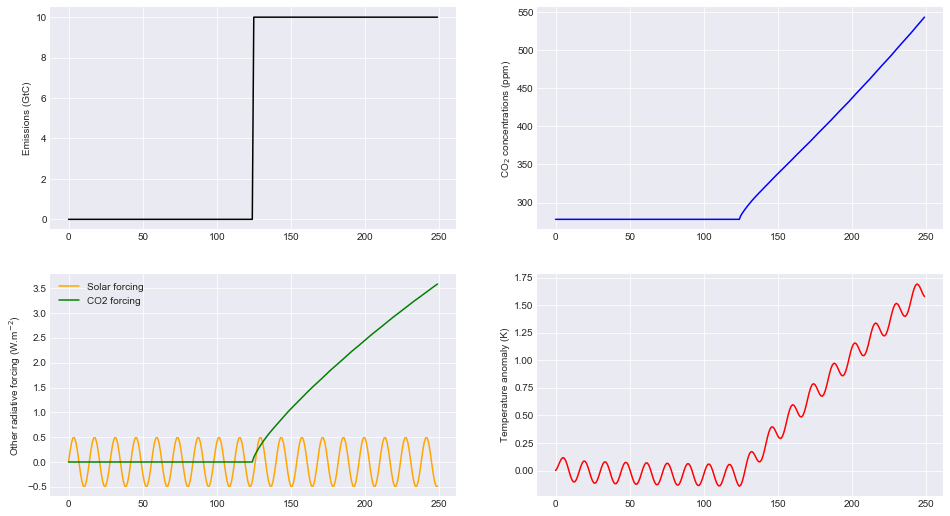

In [5]:
emissions = np.zeros((250,40))
# Unlike FAIR, we use a 40-column dataset of emissions that correspond to the RCP emissions datasets. 
# See http://www.pik-potsdam.de/~mmalte/rcps/ harmonized emissions files

emissions[:,0]  = np.arange(250)    # column zero is year
emissions[125:,1] = 10.0            # column one is fossil CO2 emissions. We'll leave other emissions as zero in this demo
nt = emissions.shape[0]
F_solar = np.zeros(nt)
for t in range(nt):
    F_solar[t] = 0.5*np.sin(2*np.pi*(t)/14.0)
    
C,F,T = fair.forward.fair_scm(emissions=emissions,
                              F_solar=F_solar)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0,nt),emissions[:,1],color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,nt),C[:,0],color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0,nt),F[:,12],color='orange', label='Solar forcing')
ax3.plot(range(0,nt),F[:,0], color='green', label='CO2 forcing')
ax3.legend()
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,nt),T,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## Natural emissions
Why is the temperature anomoly trending slightly downwards before we increase CO$_2$? We use a one-box model for greenhouse gases, but for some species (CH$_4$, N$_2$O, CF$_4$, CH$_3$Br and CH$_3$Cl) there are natural emissions that contribute to the total atmospheric concentration. For CH$_4$ and N$_2$O the default case is to take an average of the emissions over the industrial era that roughly equals the correct present-day concentrations. For CF$_4$, CH$_3$Br and CH$_3$Cl we take the RCP approach of including the natural emissions in the total reported in the dataset. If we aim for a more pre-industrial balance, we can correct this negative temperature anomoly:

Text(0,0.5,u'Temperature anomaly (K)')

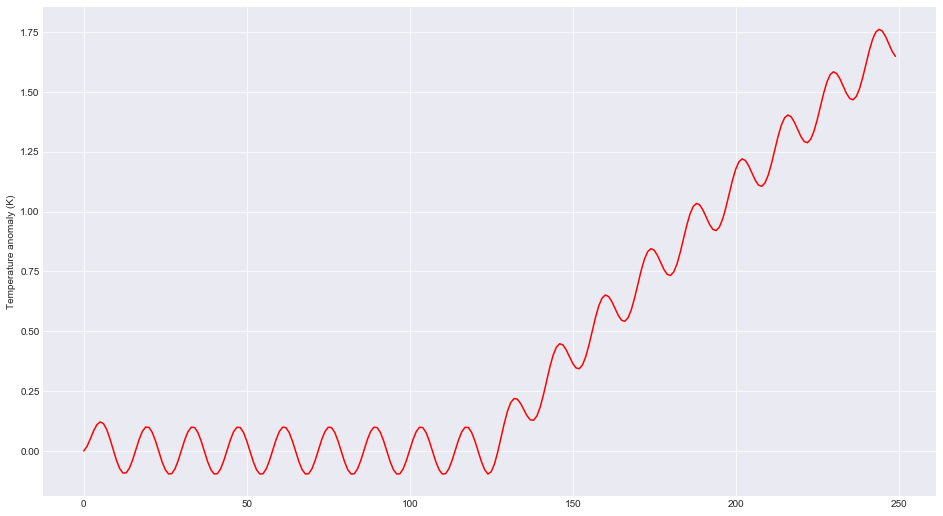

In [10]:
emissions[:,12] = 0.01076   # CF4
emissions[:,38] = 157.267   # CH3Br
emissions[:,39] = 3100.211  # CH3Cl
C,F,T = fair.forward.fair_scm(emissions=emissions,
                              F_solar=F_solar,
                              natural=[209.5, 11.16])  # CH4 and N2O

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,nt),T,color='red')
ax.set_ylabel('Temperature anomaly (K)')

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios

Text(0,0.5,u'Temperature anomaly (K)')

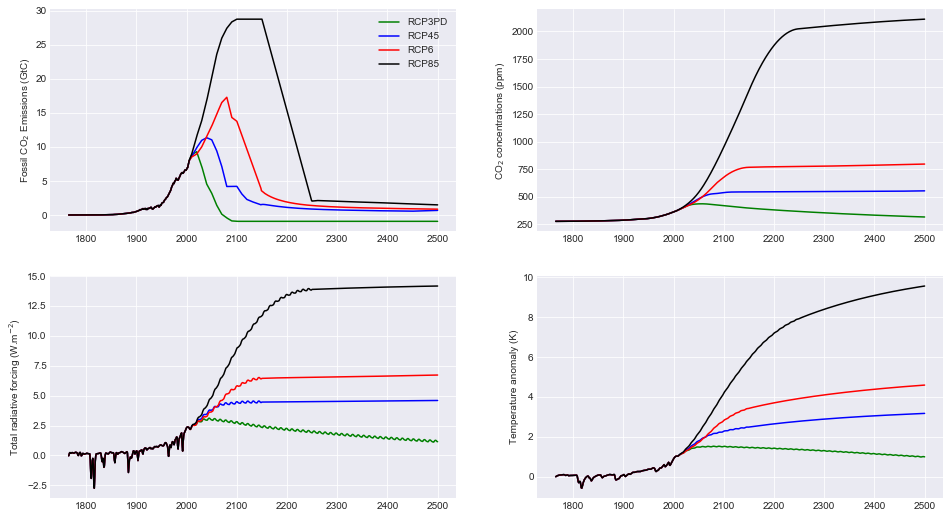

In [13]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

C,F,T = fair.forward.fair_scm(emissions  = rcp3pd.Emissions.emissions,
                              F_solar    = rcp3pd.Forcing.solar,
                              F_volcanic = rcp3pd.Forcing.volcanic)
ax1.plot(rcp3pd.Emissions.year, rcp3pd.Emissions.co2_fossil, color='green', label='RCP3PD')
ax2.plot(rcp3pd.Emissions.year, C[:,0], color='green')
ax3.plot(rcp3pd.Emissions.year, np.sum(F, axis=1), color='green')
ax4.plot(rcp3pd.Emissions.year, T, color='green')

C,F,T = fair.forward.fair_scm(emissions  = rcp45.Emissions.emissions,
                              F_solar    = rcp45.Forcing.solar,
                              F_volcanic = rcp45.Forcing.volcanic)
ax1.plot(rcp45.Emissions.year, rcp45.Emissions.co2_fossil, color='blue', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, C[:,0], color='blue')
ax3.plot(rcp45.Emissions.year, np.sum(F, axis=1), color='blue')
ax4.plot(rcp45.Emissions.year, T, color='blue')

C,F,T = fair.forward.fair_scm(emissions  = rcp6.Emissions.emissions,
                              F_solar    = rcp6.Forcing.solar,
                              F_volcanic = rcp6.Forcing.volcanic)
ax1.plot(rcp6.Emissions.year, rcp6.Emissions.co2_fossil, color='red', label='RCP6')
ax2.plot(rcp6.Emissions.year, C[:,0], color='red')
ax3.plot(rcp6.Emissions.year, np.sum(F, axis=1), color='red')
ax4.plot(rcp6.Emissions.year, T, color='red')

C,F,T = fair.forward.fair_scm(emissions  = rcp85.Emissions.emissions,
                              F_solar    = rcp85.Forcing.solar,
                              F_volcanic = rcp85.Forcing.volcanic)
ax1.plot(rcp85.Emissions.year, rcp85.Emissions.co2_fossil, color='black', label='RCP8.5')
ax2.plot(rcp85.Emissions.year, C[:,0], color='black')
ax3.plot(rcp85.Emissions.year, np.sum(F, axis=1), color='black')
ax4.plot(rcp85.Emissions.year, T, color='black')

ax1.set_ylabel('Fossil CO$_2$ Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Total radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)')